# <b>Fire - Weather - Index</b>

## Problem Setting

The problem setting of this project is to predict the affected area (in hectar) by wild fires based on wheather data. Based on the prediction of the by fire affected area, weather data can be reconciled and used to assess the threat of a wild fire. Given dataset of the Fire-Wheather-Index (FWI) $D = {x_i, y_i} $ where i ranges from 1 to n and n is the total number of instances ($n = 517$) a model should be learned that maps input attributes $ x_i $ to target variable $y_i$. Each instance $x_i$ is a vector with 12 attributes:

- <b>X</b>     (X-coordinate of the fire in the park: $1$ to $9$)
- <b>Y</b> (Y-coordinate of the fire in the park: $2$ to $9$)
- <b>month</b>    ("jan" to "dec")
- <b>day</b>   (day: "mon" bis "sun")
- <b>FFMC</b>  (FFMC index of the FWI system: $18.7$  to  $96.2$)
    - moisture conitions for shaded litter, the higher the drier
- <b>DMC</b>   (DMC index of the FWI system: $1.1$ to $291.3$)
    - moisture content loosely compacted organic layers, the higher the drier
- <b>DC</b>    (DC index of the system: $7.9$ bis $860.6$)
    - inidicator for seasonal drought, the higher the drier
- <b>ISI</b>   (ISI index of the FWI systems: $0.0$ to $56.1$)
    - combining effect of wind and FFMC, rate for spread of fire, higher better spread of fire
- <b>temp</b>  (temperature in degrees Celsius: $2.2$ to $33.3$)
- <b>RH</b> (relative humidity in %: $15$ to $100$)
    - realative humidity, the higher more humidity
- <b>wind</b> (wind velocity in $km/h: 0.4$ to $9.4$)
- <b>rain</b> (rainfall in $mm/m^2$ : $0.0$ to $6.4$)

The target variable $area$ expresses the forest area that has been burnt in hectare: $0.09$ to $1090.84$. Since the target variable is continous this is a regression problem.

Which Methods? :
- > Linear Regression as basline model
- > Random Forests



In [151]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# google drive
path = "/content/drive/MyDrive/Colab Notebooks/fire_data/fires.csv"
# local
path = "./rawdata/fires.csv"


In [4]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler as MinMax # MinMax Scaler
from sklearn.preprocessing import StandardScaler as zscore # zscore

raw_df = pd.read_csv(path, sep=",")
# print(np.shape(raw_df.values))
col_names = raw_df.columns

# print(col_names[12])
# print(np.shape(col_names))

## extracting data
# eig sinds 13 columns, aber mit pd.DataFrame gibts hier eine extra column (Index),

fire_data = pd.DataFrame(raw_df.values) #pd datafram


fire_data.columns = col_names # use columns names for dataframe

## object to convert numeric columns
# errors='coerce' to replace any non-numeric values with NaN.
fire_data[fire_data.columns.difference(["month", "day"])] = fire_data[fire_data.columns.difference(["month", "day"])].apply(pd.to_numeric, errors='coerce')
# check datafram types :
# print(fire_data.dtypes)

fire_data_dex= fire_data.copy() # dataframe solely for data exploration
# fire_data_dex = fire_data caution! this would just create a reference to the same memory place



## Data Exploration and Preprocessing

### Data Exploration


In [154]:
## Integer Mapping for categorical features
#fire_data_dex = fire_data # dataframe solely for data exploration
# ordinal relationship introduced
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
              'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

fire_data_dex["month"] = list(map(lambda x: month_dict[x], fire_data_dex["month"]))
day_dict = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5,'sat': 6, 'sun':7 }
fire_data_dex["day"] = list(map(lambda x: day_dict[x], fire_data_dex["day"]))

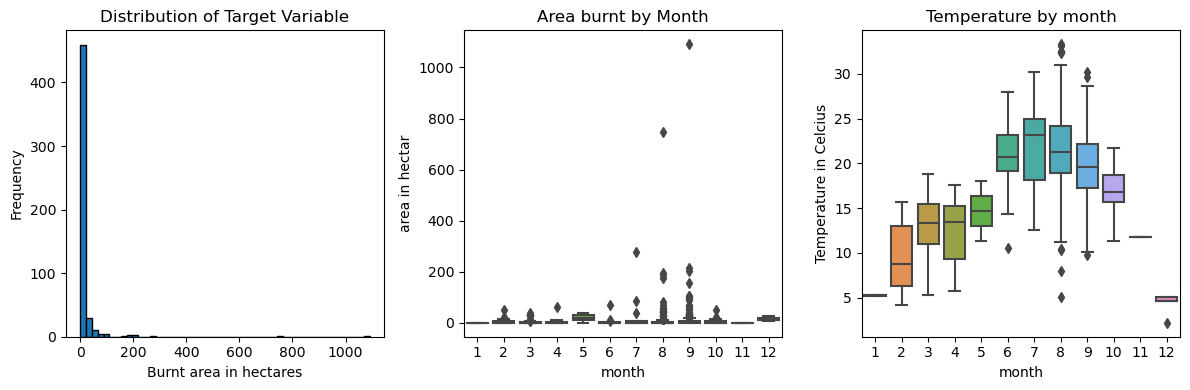

In [155]:

# figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 2 columns

# plot the histogram on the left subplot
axes[0].hist(fire_data_dex['area'], bins=50, edgecolor='black')
axes[0].set_title('Distribution of Target Variable')
axes[0].set_xlabel('Burnt area in hectares')
axes[0].set_ylabel('Frequency')

# plot the boxplot on right subplot
sns.boxplot(data=fire_data_dex, x='month', y=fire_data_dex['area'], ax=axes[1])
axes[1].set_title('Area burnt by Month')
axes[1].set_ylabel('area in hectar')
# plot the boxplot on right subplot
sns.boxplot(data=fire_data_dex, x='month', y='temp', ax=axes[2])
axes[2].set_title('Temperature by month')
axes[2].set_ylabel('Temperature in Celcius')
# Display the plots
plt.tight_layout()  # spacing between plots
plt.show()

## Plot burnt area with respect to X,Y >> include into learning if seem to be patterns related to the spatial location


- Imbalanced Target: Burnt Area
- annual trend month and temp
- categorical feature, day and month might be important

### Data Exploration: Numeric Summary
- distribution types
- area non-uniformly :  area'= log(1 + area) logarithmic scaling, use with exponential grow patterns
- Z-score normalization, for linear regression w/ L2 regularizer

In [156]:
# numeric columns in the DataFrame
# numeric_columns = fire_data.select_dtypes(include=[np.number])
summary = fire_data_dex.drop(columns=["day","month"]).describe()

# Print the summary
print(summary)
 ## !visualize distribution for each column
 ## not for the coordinates




                X           Y        FFMC         DMC          DC         ISI   
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000  \
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655

In [157]:
"""# create PairGrid
g = sns.PairGrid(fire_data_dex[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']])
g = g.map_diag(sns.histplot)  # histograms on diagonal
g = g.map_offdiag(sns.scatterplot)  # scatter plots off-diagonal
plt.show()
"""

"# create PairGrid\ng = sns.PairGrid(fire_data_dex[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']])\ng = g.map_diag(sns.histplot)  # histograms on diagonal\ng = g.map_offdiag(sns.scatterplot)  # scatter plots off-diagonal\nplt.show()\n"

![Alt text](image-1.png)

### Scaling/Normalization for Linear Regression and Neural Network
Goal is standardization, same scale for the numeric features
| Feature | Scaling/Norm        | Scale        | Reason  |
|---------|---------------------|--------------|---------|
| area    | log(1 + area)       | (0 - 1)      | Skewness, many zeros: add const=1, high values: log |
| rain    |  log(1 + rain)+MinMax| (0 - 1)      | Outliers+many zeros |
| wind    | z-score             | (zero - mean)| Small range, platt verteilung |
| RH      | log(1 + RH), z-score             | (zero - mean)| positive skewness, Widely spread |
| temp    | z-score             | (zero - mean)| Normally distributed, no outliers, let's normalize |
| ISI     | z-score             | (zero - mean)| Normalize, max far away from 78% percentile |
| DC      | z-score             | (zero - mean)| Normalize, wide range and slight skewness |
| DMC     | z-score             | (zero - mean)| Widely spread, platt verteilung |
| FFMC    | z-score             | (zero - mean)| Clustered around mean 90, outliers on low side |
| X & Y   | Min/Max             | (0 - 1)      | To account for limited range, but keep intuitive character (no negative values) |

side note:
> z-score is outlier robust

> Min/Max outlier sensitive

In [158]:
#  area
fire_data_dex['area_log'] = fire_data_dex['area'].apply(lambda x: np.log(1 + x))
# rain
fire_data_dex['rain_logminmax'] = fire_data_dex['rain'].apply(lambda x: np.log(1 + x))
fire_data_dex['rain_logminmax'] = MinMax().fit_transform(fire_data_dex[['rain_logminmax']])

# multiple columns z-scoring
#from sklearn.preprocessing import StandardScaler as zscore
to_zscore = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'wind']
zscored_col = [col + '_zs' for col in to_zscore]
fire_data_dex[zscored_col] = zscore().fit_transform(fire_data_dex[to_zscore])

## Skewness
# RH_zs, positve/right Skewness, log Transformation (x = log(c+x))
# DC_zs, negative/left Skewness, inverse Transformation (1/x)
fire_data_dex['RH_logzs'] = fire_data_dex['RH'].apply(lambda x: np.log(1 + x))
fire_data_dex['RH_logzs'] = zscore().fit_transform(fire_data_dex[['RH_logzs']])
# fire_data_dex['DC_invzs'] = fire_data_dex['DC'].apply(lambda x: 1/x if x != 0 else 0)
# fire_data_dex['DC_invzs']= zscore().fit_transform(fire_data_dex[['DC_invzs']])
#fire_data_dex = fire_data_dex.drop(columns=['RH_zs', 'DC_zs'])


# X Y - coordinates, MinMax Transform
to_minmax = ['X', 'Y']
minmaxed_col = [col + '_minmax' for col in to_minmax]
fire_data_dex[minmaxed_col] = MinMax().fit_transform(fire_data_dex[to_minmax])



In [159]:
# numeric columns in the DataFrame
summary = fire_data_dex.drop(columns=['X', 'Y','day','month','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain','area']).describe()

# Print the summary
print(summary)
 ## !visualize distribution for each column
 ## not for the coordinates



         area_log  rain_logminmax       FFMC_zs        DMC_zs         DC_zs   
count  517.000000      517.000000  5.170000e+02  5.170000e+02  5.170000e+02  \
mean     1.111026        0.005264 -1.752306e-15 -2.748715e-17  6.871787e-17   
std      1.398436        0.054173  1.000969e+00  1.000969e+00  1.000969e+00   
min      0.000000        0.000000 -1.304582e+01 -1.715608e+00 -2.179108e+00   
25%      0.000000        0.000000 -8.063453e-02 -6.606652e-01 -4.448281e-01   
50%      0.418710        0.000000  1.732292e-01 -4.020255e-02  4.691190e-01   
75%      2.024193        0.000000  4.089598e-01  4.927389e-01  6.696628e-01   
max      6.995620        1.000000  1.007353e+00  2.819865e+00  1.261610e+00   

             ISI_zs       temp_zs       wind_zs      RH_logzs    X_minmax   
count  5.170000e+02  5.170000e+02  5.170000e+02  5.170000e+02  517.000000  \
mean   1.030768e-17  2.542561e-16 -4.191790e-16  1.230050e-15    0.458656   
std    1.000969e+00  1.000969e+00  1.000969e+00  1.000969

In [160]:
"""# create PairGrid
g = sns.PairGrid(fire_data_dex[['X_minmax', 'Y_minmax', 'FFMC_zs', 'DMC_zs', 'DC_zs', 'ISI_zs', 'temp_zs', 'RH_logzs', 'wind_zs', 'rain_logminmax', 'area_log']])
g = g.map_diag(sns.histplot)  # histograms on diagonal
g = g.map_offdiag(sns.scatterplot)  # scatter plots off-diagonal
plt.show()"""


"# create PairGrid\ng = sns.PairGrid(fire_data_dex[['X_minmax', 'Y_minmax', 'FFMC_zs', 'DMC_zs', 'DC_zs', 'ISI_zs', 'temp_zs', 'RH_logzs', 'wind_zs', 'rain_logminmax', 'area_log']])\ng = g.map_diag(sns.histplot)  # histograms on diagonal\ng = g.map_offdiag(sns.scatterplot)  # scatter plots off-diagonal\nplt.show()"

![Alt text](image-2.png)


### Preprocessing
#### One-Hot-Encoding

Avoid ordinal Relationshipt : Jan lt Feb. Mo lt Tuesday

Expanding feature space, making dataset sparse -> increase computation

Regarding one-hot-encoding "day" and "month" cardinality would increase.
We would increase coloumn count by 19 (7 + 12)




### Prepocessing Pipline

In [161]:
def preproc_df(df, target, standardize = True, skew=False):
    """
    Preprocess Dataframe fire_data according to Dataexploration

    Parameters:
    - df (DataFrame): input DataFrame (fire_data)
    - target (Series): target variable (pd series)
    - standardize (bool, default: True): if True: perform standardization on specified columns
    - skew (bool, default: False): effective only if standardize=False, skew=True applies skewness correction to the 'RH' column.

    returns:
    - processed_df (dataframe)
    - processed_target (pd series)
    """

    processed_df = df.copy()  # cpy of the input df to avoid modifying directly
    processed_target = target.copy()

    if standardize:
      print(" Preprocessing: standardized")
      # log transform and scale 'area' column
      #processed_df['area_log'] = processed_df[target].apply(lambda x: np.log(1 + x))
      processed_target = target.apply(lambda x: np.log(1 + x))
      processed_target.name = 'area_log'

      # log transform and Min-Max scale 'rain' column
      processed_df['rain_logminmax'] = processed_df['rain'].apply(lambda x: np.log(1 + x))
      processed_df['rain_logminmax'] = MinMax().fit_transform(processed_df[['rain_logminmax']])

      #z-score scaling for specified columns
      to_zscore = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'wind']
      zscored_col = [col + '_zs' for col in to_zscore]
      processed_df[zscored_col] = zscore().fit_transform(processed_df[to_zscore])

      # skewness adjustments
      processed_df['RH_logzs'] = processed_df['RH'].apply(lambda x: np.log(1 + x))
      processed_df['RH_logzs'] = zscore().fit_transform(processed_df[['RH_logzs']])

      # Min-Max scaling for coordinates
      to_minmax = ['X', 'Y']
      minmaxed_col = [col + '_minmax' for col in to_minmax]
      processed_df[minmaxed_col] = MinMax().fit_transform(processed_df[to_minmax])

      # One-hot encoding
      # if e.g. test set might not have all months or days, features are missing 

      processed_df = pd.get_dummies(processed_df, columns=['month', 'day'])
      #processed_df = processed_df.drop(columns=["day_sun", "month_dec"])
      # when datafram does not have all possible days/months add them as zero-columns 
      # to ensure consistency between train and test set later
      expected_columns = ['month_jan', 'month_feb', 'month_mar', 
                    'month_apr','month_may', 'month_jun',
                    'month_jul', 'month_aug', 'month_sep',
                    'month_oct', 'month_nov', 'month_dec', 
                    'day_mon',  'day_tue','day_wed',
                    'day_thu','day_fri', 'day_sat',
                    'day_sun']
      for col in expected_columns:
          if col not in processed_df.columns:
              processed_df[col] = 0
      # also the order matters
      # reorder columns
      all_cols = list(processed_df.columns)
      for col in expected_columns:
          all_cols.remove(col)
      ordered_columns = all_cols + expected_columns
      processed_df = processed_df[ordered_columns]
      
      # drop the original, unprocessed columns
      columns_to_drop = to_zscore + to_minmax + ['rain', 'RH', 'month', 'day']
    else:
      print(" Preprocessing: One-Hot encode only")
      # One-hot encoding
      processed_df = pd.get_dummies(processed_df, columns=['month', 'day'])
      #processed_df = processed_df.drop(columns=["day_sun", "month_dec"])

      # toggle skewness and test w/ and w/o
      if skew:
        # skewness adjustments
        print('with Skewness Adjustment')
        processed_df['RH_logzs'] = processed_df['RH'].apply(lambda x: np.log(1 + x))
        processed_df['RH_logzs'] = zscore().fit_transform(processed_df[['RH_logzs']])
        # drop the original, unprocessed columns
        columns_to_drop = ['month', 'day', 'RH']
      else:
        # drop the original, unprocessed columns
        columns_to_drop = ['month', 'day']

    processed_df = processed_df.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' in case some columns dont exist

    return processed_df, processed_target


### Training

> Linear Regression with L2 (ridge) regularizer (hyperparameter: lambda)
- L2: because shrinks coefficients (instead of turning them to zero like lasso) which is better for a small dataset
- because lasso tends to make dataset sparse (less features)



### Evluation
- split: 80/20%
    - 80% (for cross validation),
    - 20% (hold-out) later after training
- k-fold cross validation
    - stratified sampling and splitting
- evaluate regression models using the Root Mean Squared Error (RMSE).
    - keeps error in the original units of the target variable.
        > area was log transformed, so RMSE will be in this scale
    - consider higher weight to larger errors due to squaring


$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

where:

- \( n \) is the number of observations,
- \( y_i \) is the actual value of the target variable for observation \( i \),
- $\hat{y}_i$ is the predicted value of the target variable for observation \( i \).






In [162]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
#from sklearn.linear_model import LinearRegression  ## LR
from sklearn.model_selection import learning_curve

from sklearn.linear_model import Ridge #LRridge
from sklearn.neural_network import MLPRegressor     ## NN
from sklearn.svm import SVR ## 
from sklearn.ensemble import RandomForestRegressor  ## RF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from joblib import dump, load #to save models in files

In [163]:
def get_model(model_name):
    if model_name == 'randomForest':
        return RandomForestRegressor()
    elif model_name == 'ridgeRegression':
        print('ridgeRegression')
        return Ridge()
    elif model_name == 'MLPRegressor':
        return MLPRegressor()
    elif model_name == 'SVR':
        return SVR()

In [164]:
def evaluate_model3(df, target, model, standardize, param_grid, thr_bins = [-np.inf, 0.01, 0.52, 6.57, 1090.84], bin_label=[1,2,3,4], kfolds=5, skew=False, plot = False, scoring='neg_mean_squared_error'):
    """
    Parameters:
    - df: DataFrame
    - target: str, target variable.
    - model: scikit-learn model (regression)
    - standardize: bool, standardize (from preproc_df).
    - thr_bins: list, thresholds for binning target variable.
    - skew: bool, apply skewness correction for RH (from preproc_df, if standardize=False).
    - plot: bool
    - param_grid: dict, parameter grid for GridSearchCV

    Returns:
    (plot=False):
        - RMSE scores
    (plot=True):
        - learning curve
        - train_scores RSME scores for each fold in cross-validation
    """

    ##### PREPROCESSING
    if standardize:
        X, y = preproc_df(df, target, standardize, skew)
    else:
        X = df
        y = target

    ##### SAMPLING
    # creating bins for target, startified sampling
    bins = pd.cut(y, bins=thr_bins, labels=bin_label)
    # stratified sampling needed for each fold
    # .split(X,y_labels) method for StratifiedKFold: "Generate indices to split data into training and test set."
    # is normally used for classification task with classes as target, but since target is binned
    # .split() could be used for stratified sampling
    strat_kf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=35007).split(X, bins)
    # returns indices for stratified training and test sets based on the binning
    # stratified sampling indeces use for crossvalidation

    #### GRID SEARCH, CROSSVALIDATION, FITTING
    grid_searchcv = GridSearchCV(model, param_grid=param_grid, cv=strat_kf, scoring=scoring).fit(X, y)
    # fetch model for return
    tuned_model = grid_searchcv.best_estimator_
    if scoring == 'neg_mean_squared_error':
        # RMSE, negate because scoring neg_mean_sqared_error ouput negative MeanSquaredError
        score = np.sqrt(-grid_searchcv.best_score_)
    elif scoring == 'neg_mean_absolute_error':
        # MAE, negate because scoring neg_mean_absolute_error outputs negative MAE
        score = -grid_searchcv.best_score_
    

    #### RETURN
    if not(plot):
        return score, tuned_model
    else:
        # strat_kf generator will get consumed by gridsearhc
        # redeclare
        strat_kf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=35007).split(X, bins)
        train_sizes, train_scores, test_scores = learning_curve(
            tuned_model,
            X, y,
            cv=strat_kf,
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 10)
        )
        # train_sizes=np.linspace(0.1, 1.0, 10): validation scores for 10% to 100% of the training data (increasing size of the training set by 10%)
        # np.linspace(0.1, 1.0, 10): from 0.1 to 1, 10 values equally spaced

        plt.figure()
        plt.title("Learning Curve")
        plt.xlabel("Size of Training Set")
        if scoring == 'neg_mean_squared_error':
            train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
            test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
            plt.ylabel("Mean RMSE Score")
        elif scoring == 'neg_mean_absolute_error':
            train_scores_mean = np.mean(-train_scores, axis=1)  # Negate to get positive values
            test_scores_mean = np.mean(-test_scores, axis=1)  # Negate to get positive values
            plt.ylabel("Mean MAE Score")
        
        plt.grid()

        # x-axis actual size of the training set (10%-100%)
        # y-axis the RMSE
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

        plt.legend(loc="best")
        plt.show()
        return np.sqrt(-train_scores), tuned_model


#### Creating 80/20% Hold-Out Set
- Many zero values (skewed) use stratified sampling to ensure same distribution in splits
Basing bin edges for stratified sampling on the distribution of area (target):

| Statistic | Value       |
|-----------|-------------|
| Count      | 517.000000  |
| Mean      | 12.847292   |
| Std       | 63.655818   |
| Min       | 0.000000    |
| 25%       | 0.000000    |
| 50%       | 0.520000    |
| 75%       | 6.570000    |
| Max       | 1090.840000 |


> Bin 1: 0 to 0 (Q1)                technically : -inf to 0.01

> Bin 2: >0 to 0.52 (Q2/Median)

> Bin 3: >0.52 to 6.57 (Q3)

> Bin 4: >6.57 to 1090.84 (Max)


In [165]:
bins = pd.cut(fire_data['area'], bins=[-np.inf, 0.01, 0.52, 6.57, 1090.84], labels=[1, 2, 3, 4])
# warning from splitting, in StratifiedKfold: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
# warnings.warn( <<< do fewer bins?
# bins = pd.cut(fire_data['area'], bins=[-np.inf, 0.01, 0.52, 1090.84], labels=[1, 2, 3])

X_train, X_test, y_train, y_test = train_test_split(fire_data.drop('area', axis=1), fire_data['area'], test_size=0.2, stratify=bins, random_state=35007)


#### Hyperparameter Tuning

> Ridge Regression (L2 regularizer):

$$\text{Objective} = ||y - X\beta||^2_2 + \alpha ||\beta||^2_2$$

$\alpha$: regularization strength
- the larger the stronger the regularization
- shrinking the coefficients $\beta$ toward zero (possibly simpler model)

fit_intercept:
- allow and calculate intercept $y=X\beta+b$
- if False forcing hyperplane to pass origin

> Random Forest:

n_estimator: number of trees in forest
- more trees, more opportunity to learn from data, better performance
- more trees more computation time, at some number no significant increase in performance

max_depth: max depth of each decision tree
- more depth, more complexity, potentially captureing complexity of data
- more depth higher chance of overfitting, less depth underfitting
- deeper trees more computational effort



##### Ridge Regression

ridgeRegression
 Preprocessing: standardized


/home/t44p/anaconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/t44p/anaconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


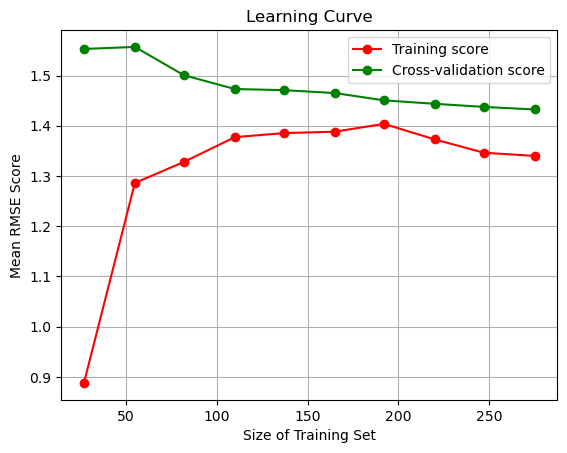

[[1.02711921 0.83416951 0.80285651]
 [1.28079822 1.30662963 1.27081469]
 [1.24804361 1.40675241 1.32914431]
 [1.29351328 1.43833906 1.40009559]
 [1.26534106 1.41806763 1.47240211]
 [1.31554238 1.40853086 1.44060371]
 [1.28973302 1.44802431 1.47354654]
 [1.25775921 1.41305958 1.44716898]
 [1.23882142 1.38593524 1.41412607]
 [1.22614242 1.38068418 1.41283329]]
Ridge(alpha=3.5)


In [166]:
a_model = get_model(model_name='ridgeRegression')
param_grid = {"alpha": np.array(np.arange(1, 4, 0.5)), "fit_intercept": [False, True]}
# fit_intercept seems to be always chosen as true, model returned withouth the parameter,
# but if i force to be [False, False] then model will be returned with fit_intercept=False.
binning = [-np.inf, 0.01, 0.52, 6.57, 1090.84]
bin_label = [1, 2, 3, 4]

rmse_ridge, ridgeReg_tuned = evaluate_model3(X_train, y_train,
                a_model,
                param_grid=param_grid,
                standardize=True,
                thr_bins=binning,
                bin_label=bin_label,
                kfolds=3,
                plot=True)
dump(ridgeReg_tuned, 'ridgeReg_tuned.pkl') # save the model as .pkl
print(rmse_ridge)
print(ridgeReg_tuned)


comment: 
- (column) for each fold (e.g. kfold=3) a 10 RMSE value were produced
- (row)for each 10% (10-100%) sample size the mean RMSE was used as a point : mean over row
- (row) first point is mean over first row
- (row) last point is mean over last row

> alpha

- model consistently chooses the highest $\alpha$ values
- might indicate that the model is oversimplifying to avoid overfitting -> danger of underfitting? 
- ***Trying to max out alpha***

ridgeRegression
 Preprocessing: standardized


/home/t44p/anaconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


/home/t44p/anaconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


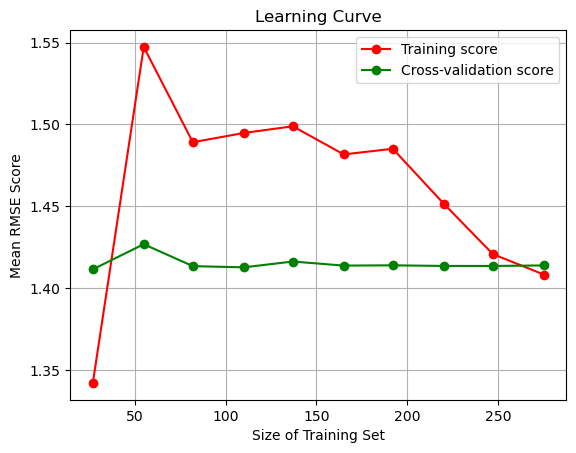

[[1.3537743  1.35640029 1.31670299]
 [1.42043597 1.60377368 1.61775714]
 [1.38238663 1.55153338 1.53355737]
 [1.43259845 1.52288528 1.52892516]
 [1.39369071 1.50149029 1.60150069]
 [1.41220558 1.50006953 1.53295251]
 [1.37162163 1.52597975 1.55791182]
 [1.33463495 1.49083447 1.52951464]
 [1.31443565 1.45685456 1.49147869]
 [1.29881864 1.44918333 1.47731741]]
Ridge(alpha=3.5)


In [167]:
a_model = get_model(model_name='ridgeRegression')
param_grid = {"alpha": np.array(np.arange(1378, 1410, 1)), "fit_intercept": [False, True]}
# fit_intercept seems to be always chosen as true, model returned withouth the parameter,
# but if i force to be [False, False] then model will be returned with fit_intercept=False.
binning = [-np.inf, 0.01, 0.52, 6.57, 1090.84]
bin_label = [1, 2, 3, 4]

rmse_ridge, ridgeReg_tuned2 = evaluate_model3(X_train, y_train,
                a_model,
                param_grid=param_grid,
                standardize=True,
                thr_bins=binning,
                bin_label=bin_label,
                kfolds=3,
                plot=True)
dump(ridgeReg_tuned2, 'ridgeReg_tuned2.pkl') # save the model as .pkl
print(rmse_ridge)
print(ridgeReg_tuned)


training curve:
- initially shoots up and then start to decrease indicating that model is initially too complex (high variance) 
- then becomes more generalized with more training data added.

Cross-Validation Curve:
- remains stable around 1.42, adding more data might not be improving model

Convergence:
- model still generalizes relatively good

> Conclusion
- Ridge Regression is trying to reduce magnitude of coefficients as much as possible
- leading to a simpler model, (as simple as possible) Risk of oversimplifying and underfitting
- could be to simple maybe stick with the model with lower $\alpha$ since this still generalizes good
- Test later if model type (Ridge Regression) might be to simple


##### Random Forest

 Preprocessing: standardized


/home/t44p/anaconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/t44p/anaconda3/envs/ida_tf/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


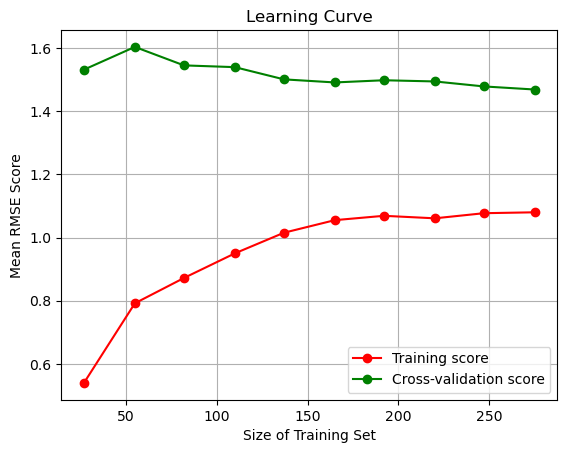

[[0.57060821 0.5653893  0.48382438]
 [0.82535868 0.77172028 0.77863808]
 [0.87522761 0.8554053  0.88533284]
 [0.93848403 0.94238276 0.9688169 ]
 [0.95422579 1.03713164 1.05422777]
 [0.99329984 1.0829955  1.08872435]
 [1.01398218 1.09887222 1.09336183]
 [1.00738363 1.08694698 1.08806392]
 [1.02416798 1.0997507  1.10705282]
 [1.00189283 1.13551071 1.10216182]]
RandomForestRegressor(max_depth=5, n_estimators=52)


In [168]:
a_model = get_model(model_name='randomForest')
param_grid = {"n_estimators": np.array(np.arange(50, 70, 1)), "max_depth": np.array(np.arange(5, 15, 1))}
binning = [-np.inf, 0.01, 0.52, 6.57, 1090.84]
bin_label = [1, 2, 3, 4]

rmse_rf, randomForReg_tuned = evaluate_model3(X_train, y_train,
                a_model,
                param_grid=param_grid,
                standardize=True,
                thr_bins=binning,
                bin_label=bin_label,
                kfolds=3,
                plot=True)
dump(randomForReg_tuned, 'randomForReg_tuned.pkl')
print(rmse_rf)
print(randomForReg_tuned)


> Training curve: 
- model is learning from Data (thats good)
- mean RMSE rises when model is exposed to more Data (successively less overfitting) (thats good)

> Validation curve: 
- mean RMSE falling, curve falls down, model generalizes well to unseen data

> Curves converging:
- do not converge completely -> model could benefit from more data (but to which extend ?)
- RMSE reasonable, like the Ridge model cross-validation curve stabilizes around 1.42 mean RMSE
- performance seems ok (to be tested on validation set)


> Hyperparameters:

max_depth:
- pipline tends to choose low max_depth values, might mean less complex model could benefit from the data with the danger of underfitting
- allow the Grid Search for very low and (dynamic) maximum depth : 
    - [None ,list(np.arange(1, 15, 1))] --> produced problems, where 50% of the fits failed
    - I will stick to list(np.arange(3, 15, 1)) to not oversimplifying the model

n_estimators:
- chosen by pipline is 52, moderate number of trees

#### 1st Conclusion
> Convert the RMSE back to the original scale:

$$\text{RMSE}_{\text{original}} = \sqrt{\exp(\text{RMSE}_{\text{log}}^2) - 1}$$



In [5]:
# 10%, 20%, 100% size training data
rmse_rf =   [[0.57060821, 0.5653893,  0.48382438], 
            [1.02416798, 1.0997507,  1.10705282],
            [1.00189283, 1.13551071, 1.10216182]]

print("revert some mean RMSE of the training curve from RandomForest Regressor back to origianl scale: \n", np.sqrt(np.exp(np.power(rmse_rf, 2)) - 1))

print("both cv-curves converge to 1.42, revert to original scale:", np.sqrt(np.exp(1.42 ** 2) - 1), "hectar")

revert some mean RMSE of the training curve from RandomForest Regressor back to origianl scale: 
 [[0.62036492 0.61373169 0.51356909]
 [1.36182476 1.53350778 1.55115866]
 [1.31476294 1.62189751 1.53931399]]
both cv-curves converge to 1.42, revert to original scale: 2.5517123179702317 hectar


- Converted mean RMSE 2.55 hectar
- seems big in the context 2.55 hectar burnt more or less .. 
- but given the unballanced data it is still reasonable, since many zero values
- another performance metric like mean absolute error (MEA) could be applied since RSME could be outlier sensitive
- here another preprocessing strategy could be considered
- models might benefit from outlier removal, feature engineering, maybe feature scaling could be adjusted


> Both models converge towards Hyperparameters that create simpler models
- could mean a less regularized models would tend to overfit the data
- simpler models could suffice
- could mean that that only a few features contribute to the prediction 

> lets check feature importance for RandomForest Regressor




##### Feature Importance Random Forest

 Preprocessing: standardized


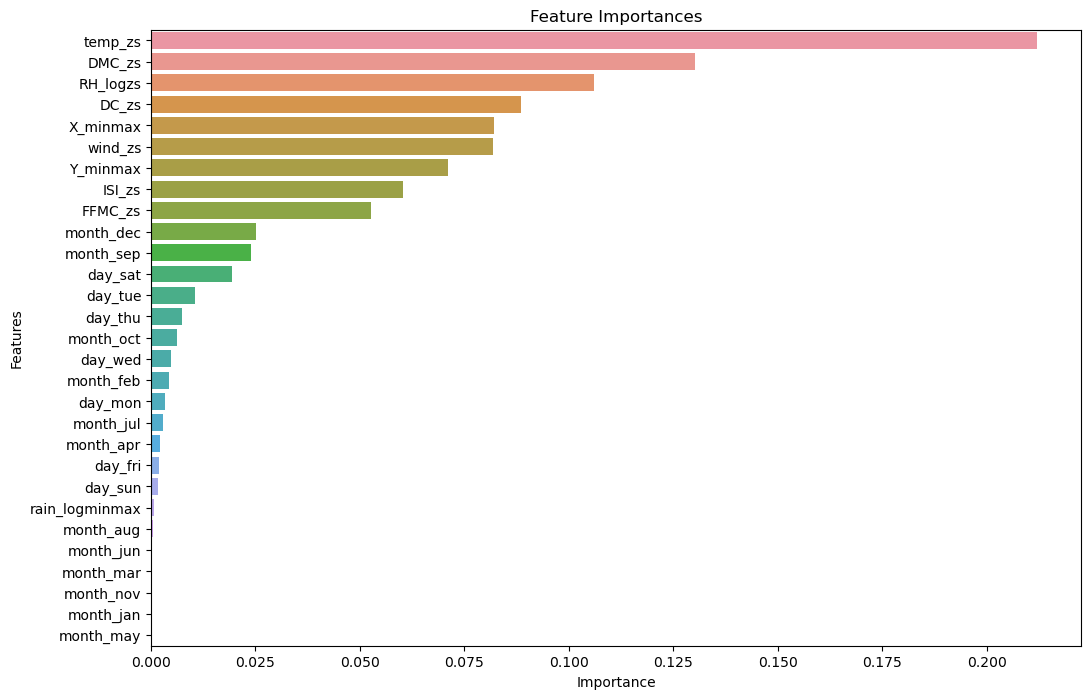

In [170]:
rf_model = load('randomForReg_tuned.pkl')
feature_importances = rf_model.feature_importances_
X_train_processed, y_train_processed = preproc_df(X_train, y_train)
# feature names
feature_names = X_train_processed.columns

# create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# print(importance_df)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
#print(importance_df)

- continuous features (e.g., temp_zs, DMC_zs, DC_zs, etc.) are contributing more to the predictions than the one-hot-encoded categorical features (from day and month). 
- makes sense considering the highly regularized models  (high $\alpha$ for Ridge, shallow max_depth for Random Forest)
    - shallow trees cannot capture complex interaction of categorical features (cannot explore interaction between so many one-hot encoded features)



- stratification for each fold each class in target should be represented equally (influenced by binning) 

- requires enough samples in each bin
- there was a warning that there where less samples than folds so binning was not suitable try different binning


##### Different Binning to account for Warnings(sample size least populated class < kfold splits)
- and consider the hyperparameters

 Preprocessing: standardized


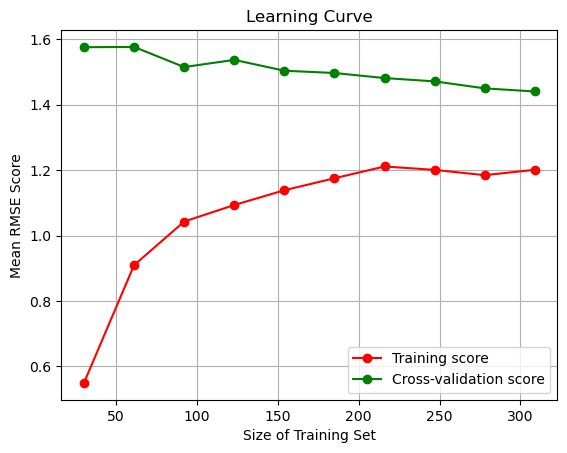

[[0.59713204 0.67139003 0.42532792 0.50345484]
 [0.97360238 0.94729731 0.78017555 0.93639547]
 [1.06284478 1.01397078 1.00726389 1.08710426]
 [1.15666263 1.03368435 1.04278829 1.14069737]
 [1.20958193 1.05039213 1.12197423 1.17254717]
 [1.23327467 1.08957122 1.15497088 1.22317466]
 [1.26085675 1.14976964 1.18753159 1.24690622]
 [1.23151994 1.1766157  1.18031829 1.21476959]
 [1.2207054  1.13581848 1.1908682  1.19151906]
 [1.22447978 1.17934296 1.18071261 1.22001686]]
RandomForestRegressor(max_depth=4, n_estimators=50)


In [171]:
a_model = get_model(model_name='randomForest')
param_grid = {"n_estimators": np.array(np.arange(50, 70, 1)), "max_depth": list(np.arange(3, 15, 1))}
binning = [-np.inf, 0.01, 0.52, 1090.84]
bin_label = [1, 2, 3]

rmse_rf, randomForReg_tuned3 = evaluate_model3(X_train, y_train,
                a_model,
                param_grid=param_grid,
                standardize=True,
                thr_bins=binning,
                bin_label=bin_label,
                kfolds=4,
                plot=True)
dump(randomForReg_tuned3, 'randomForReg_tuned3.pkl')
print(rmse_rf)
print(randomForReg_tuned3)

- performance comparable to the training before with different binning
- convergence of curves is good sign, model seems to generalize better with different binning and new set hyperparameter range

 Preprocessing: standardized


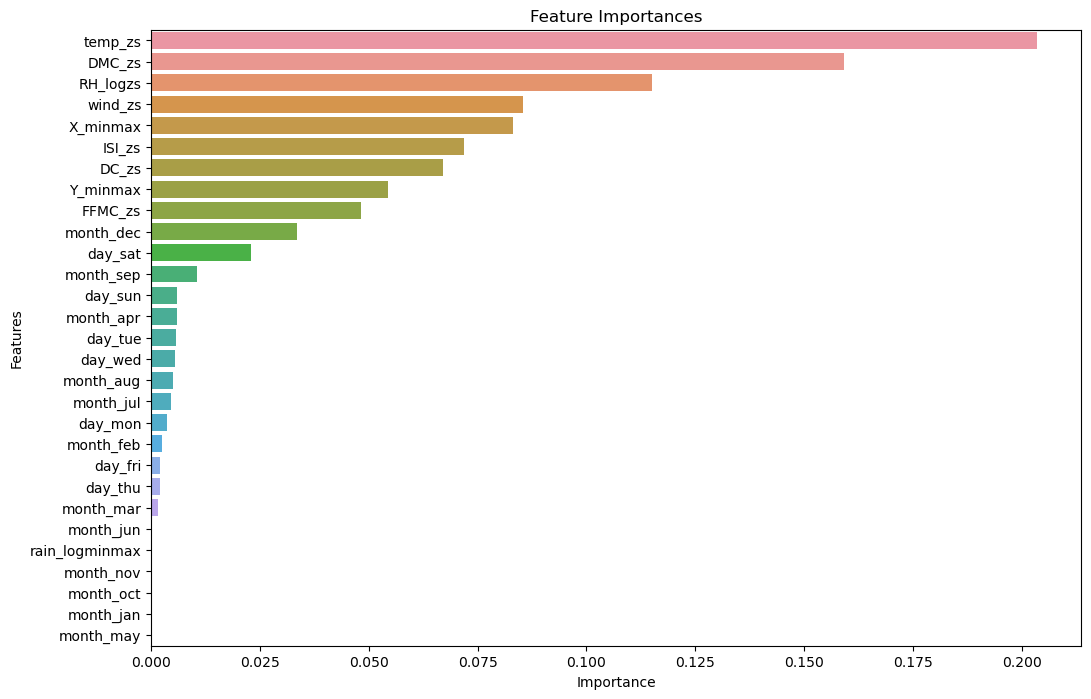

RandomForestRegressor(max_depth=4, n_estimators=50)
           Feature  Importance
5          temp_zs    0.203406
2           DMC_zs    0.159215
7         RH_logzs    0.115095
6          wind_zs    0.085520
8         X_minmax    0.083209
4           ISI_zs    0.071827
3            DC_zs    0.067135
9         Y_minmax    0.054461
1          FFMC_zs    0.048205
21       month_dec    0.033494
27         day_sat    0.022944
18       month_sep    0.010650
28         day_sun    0.006069
13       month_apr    0.005866
23         day_tue    0.005839
24         day_wed    0.005545
17       month_aug    0.004935
16       month_jul    0.004613
22         day_mon    0.003639
11       month_feb    0.002418
26         day_fri    0.002149
25         day_thu    0.001985
12       month_mar    0.001503
15       month_jun    0.000278
0   rain_logminmax    0.000000
20       month_nov    0.000000
19       month_oct    0.000000
10       month_jan    0.000000
14       month_may    0.000000


In [172]:
rf_model = load('randomForReg_tuned3.pkl')
feature_importances = rf_model.feature_importances_
X_train_processed, y_train_processed = preproc_df(X_train, y_train)
# feature names
feature_names = X_train_processed.columns

# create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# print(importance_df)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
print(rf_model)
print(importance_df)

ridgeRegression
 Preprocessing: standardized


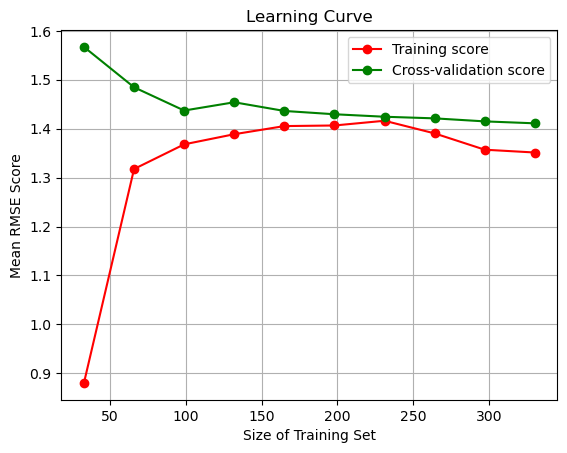

[[0.83829117 0.99361326 0.92346003 0.74585124 0.90088136]
 [1.36026886 1.42349479 1.33693011 1.14133726 1.32562553]
 [1.39482956 1.36832599 1.40514011 1.27198427 1.39945578]
 [1.44772101 1.37802166 1.43823017 1.27667879 1.40256356]
 [1.45261955 1.33250238 1.42465421 1.3615348  1.45505604]
 [1.45628451 1.3465079  1.42958185 1.34630872 1.45379983]
 [1.46413183 1.3808616  1.43661767 1.35054744 1.4486079 ]
 [1.4220659  1.35545011 1.4177083  1.33440736 1.42190076]
 [1.38579542 1.32336782 1.38476407 1.30071891 1.39034256]
 [1.38237481 1.30283111 1.3834378  1.30178479 1.38590586]]
Ridge(alpha=3.5)


In [173]:
a_model = get_model(model_name='ridgeRegression')
param_grid = {"alpha": np.array(np.arange(1, 4, 0.5)), "fit_intercept": [False, True]}
# fit_intercept seems to be always chosen as true, model returned withouth the parameter,
# but if i force to be [False, False] then model will be returned with fit_intercept=False.
binning = [-np.inf, 0.01, 0.52, 1090.84]
bin_label = [1, 2, 3]


rmse_ridge, ridgeReg_tuned3 = evaluate_model3(X_train, y_train,
                a_model,
                param_grid=param_grid,
                standardize=True,
                thr_bins=binning,
                bin_label=bin_label,
                kfolds=5,
                plot=True)
dump(ridgeReg_tuned3, 'ridgeReg_tuned3.pkl') # save the model as .pkl
print(rmse_ridge)
print(ridgeReg_tuned)


#### 2nd Conclusion
- with different binning no warning
- feature importance and performance during training are the comparable
- feature engineering startegies could be explored
- less important features could be dropped
- for the underlying data, a threshold of 0.7 could be reasonable

## Comparing and Testing the models with the test set


In [174]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def validate(model, X_test, y_test, scoring=['rmse', 'mae'], plot=True, preproc=True):
    model_name = str(model)
    """    
    Validates a regression model and returns the evaluation metrics.

    Parameters:
        model: trained model
        X_test: dataframe with test features.
        y_test: pd.series test target.
        scoring: lsit of metrics RMSE and MAe. 'rmse' and 'mae'.
        plot: toggle plotting

    Returns:
        scores: A dictionary containing the metrics.
    """
    scores = {}
    if preproc:
        X_test_processed, y_test_processed = preproc_df(X_test, y_test, standardize=True, skew=False)
        y_pred = model.predict(X_test_processed)
    else:
        X_test_processed = X_test
        y_test_processed =  y_test
        y_pred = model.predict(X_test_processed)
        

    # metrix
    if 'rmse' in scoring:
        rmse_log = np.sqrt(mean_squared_error(y_test_processed, y_pred))
        rmse_original = np.sqrt(np.exp(rmse_log**2) - 1)
        scores['rmse_original'] = rmse_original
        print(f"RMSE: {rmse_log}")
        print(f"RMSE original: {rmse_original} hectar")
        scores['rmse_log'] = rmse_log
        scores['rmse_original'] = rmse_original

    if 'mae' in scoring:
        mae = mean_absolute_error(y_test_processed, y_pred)
        print(f"MAE: {mae}")
        scores['mae'] = mae

    # plotting
    if plot:
        plt.figure(figsize=(12, 6))

        # residual plotting
        plt.subplot(1, 2, 1)
        residuals = y_test_processed - y_pred
        plt.scatter(y_pred, residuals)
        plt.title("Residual Plot (log-scale)  \n" + model_name)
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")

        # scatter plot predicted vs actual
        plt.subplot(1, 2, 2)
        # scatter plot test vs. pred
        plt.scatter(y_test_processed, y_pred)
        # plot a diagonal in range of test data, linewidth=2
        plt.plot([min(y_test_processed), max(y_test_processed)], [min(y_test_processed), max(y_test_processed)], '--', lw=2)
        plt.title("Predicted vs Actual (log-scale) \n" + model_name)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")

        plt.tight_layout()
        plt.show()

    return scores


 Preprocessing: standardized
RMSE: 1.347303499921124
RMSE original: 2.267701180845027 hectar
MAE: 1.1307364178636647


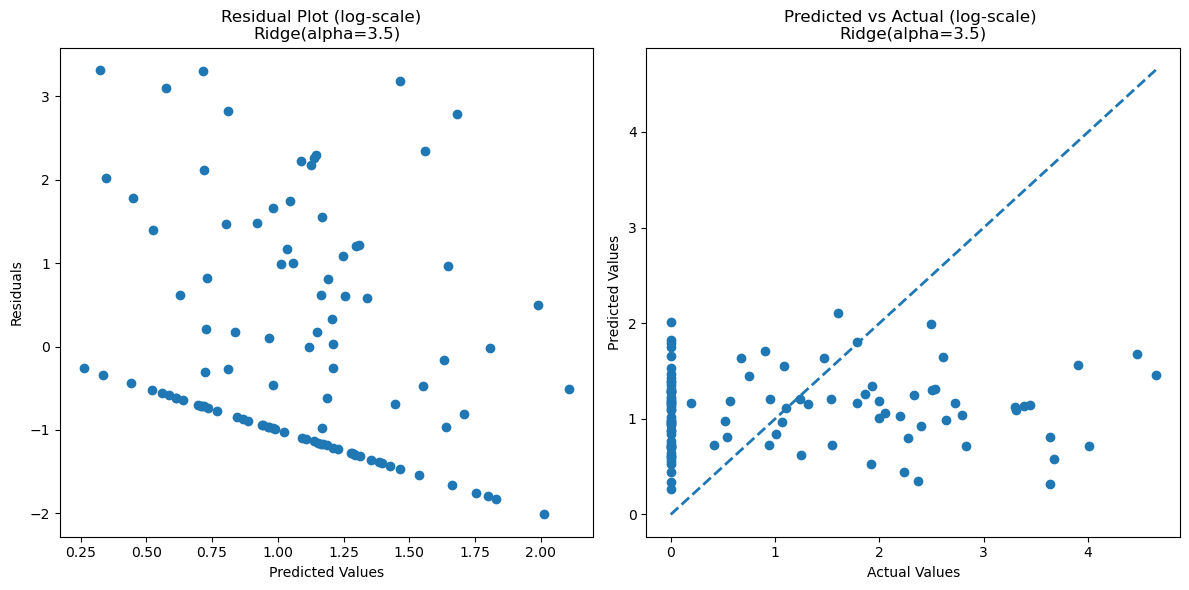

{'rmse_original': 2.267701180845027,
 'rmse_log': 1.347303499921124,
 'mae': 1.1307364178636647}

In [175]:
ridge_model_val = load('ridgeReg_tuned3.pkl')
validate(ridge_model_val, X_test=X_test, y_test=y_test, scoring=['rmse', 'mae'], plot=True)


**Residual plot:**
- pattern, small predicted value have small residuals, higher predicted values have higher residuals
- whereby the residual=predicted values, meaning that true value was zero
- points building a diagonal line from Residual(yaxis)= 0, predicted value(x-axis)= 0.25 to Residual(yaxis)= -2, predicted value(x-axis)= 2
- other points scatter Resudal(yaxis)= -1 to 3, predicted value(x-axis)= 0.25 to 2

**Pedicted vs. Actual Plot:**
- pattern, many points building a line for Actual value(x-axis) = 0, Predicted values(y-axis) = 0.2 to 2
- rest of points scatter Actual value(x-axis) = 0.1 to 4.5, Predicted values(y-axis) = 0.2 to 2.1
- for many true=0 values the model predicted values from 0.2 to 2.1 thereby performing poorly
- for datapoints where true values are between 0.5 and 1.5 the model could predict similar values
- for datapoints where true values were higher 2 to 4.5 the model predicted smaller values between 0,2 and 2.1 


The RidgeRegression $\alpha=3.5$ seems not to be able to capture the underlying trend in the Data.
It lacks the ability to predict higher values and does no capture feature dynamics leading to zero values.
As a baseline model this could suggest that the model is not complex enough by assuming a linear relation and might be underfitting data especially for higher values. It might be possible that colinearity is affecting the model and that since I used all features this was detrimental to the models performance.

 Preprocessing: standardized
RMSE: 1.3014491712706473
RMSE original: 2.107118983846578 hectar
MAE: 1.0942514266002232


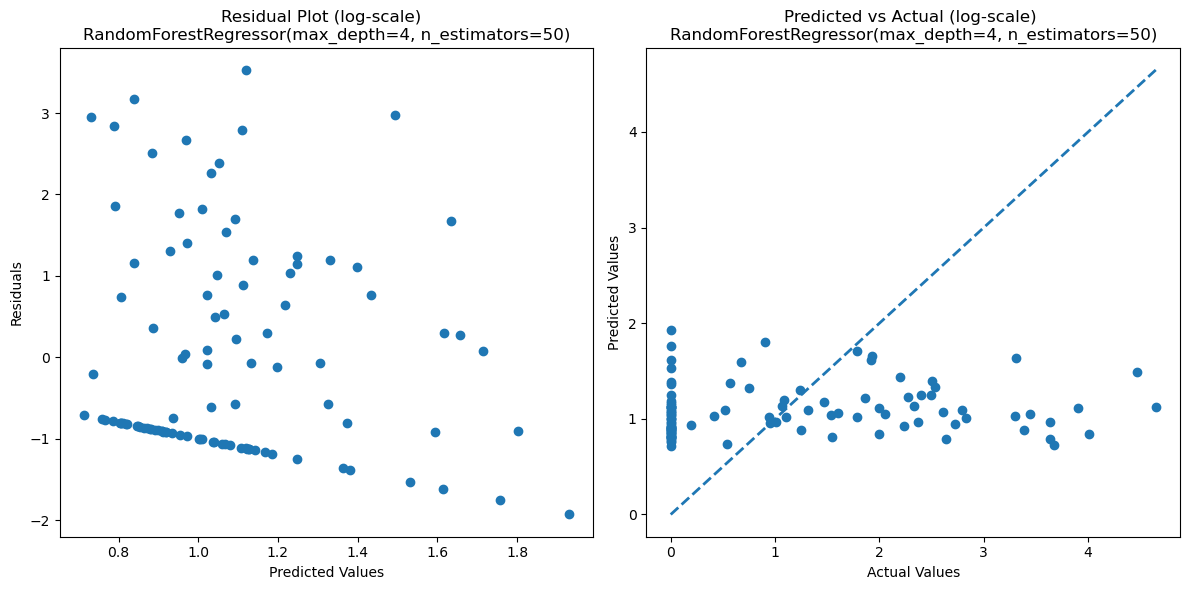

{'rmse_original': 2.107118983846578,
 'rmse_log': 1.3014491712706473,
 'mae': 1.0942514266002232}

In [176]:
rF_model_val = load('randomForReg_tuned3.pkl')
validate(rF_model_val, X_test=X_test, y_test=y_test, scoring=['rmse', 'mae'], plot=True)


**Residual plot:**
- pattern, small predicted value have small residuals, higher predicted values have higher residuals
- whereby the residual=predicted values, meaning that true value was zero
- points building a diagonal line from Residual(yaxis)= 0.2, predicted value(x-axis)= 0.6 to 
Residual(yaxis)= -1.8, predicted value(x-axis)= 1.6 with an outlier point on same line 
y=-2.7, x=2.7
- other points scatter Residual(yaxis)= -1.2 to 3.4, predicted value(x-axis)= 0.6 to 2.2

**Pedicted vs. Actual Plot:**
- pattern, many points building a line for Actual value(x-axis) = 0, Predicted values(y-axis) = 0.2 to 1.8 with an outlier Predicted values(y-axis) = 2.6, Actual value(x-axis) = 0 
- rest of points scatter Actual value(x-axis) = 0.1 to 4.5, Predicted values(y-axis) = 0.8 to 2.1
- for many true=0 values the model predicted values from 0.7 to 1.8 thereby performing poorly
- for datapoints where true values are between 0.5 and 1.5 the model could predict similar values
- for datapoints where true values were higher 2 to 4.5 the model predicted smaller values between 0,2 and 2.1 

Since both models exhibit the same Patterns this behaviour might be due to the preprocessing. 
Further it can be beneficial to check for correlation and develop a feature Engineering strategy.
Applying a complexer model could also be a way to tackle insufficiencies of the models. 

Since 75%-Quantile of the data is $2.024$ (reverse transformed: $6.57$ hectar) the majority of the data is within this range which would mean that most of the data points are either zero or small fires. Lets test whether the models could perform better assuming that the usual case would be datapoints that would lead to small fires.

In [177]:
below_75_quantile_indices = y_test[(y_test <= 2.024)& (y_test > 0)].index 

# subset of test sets using indices
X_test_below_75 = X_test.loc[below_75_quantile_indices]
y_test_below_75 = y_test.loc[below_75_quantile_indices]

 Preprocessing: standardized
RMSE: 0.7661092249137366
RMSE original: 0.8935584445739223 hectar
MAE: 0.6110301973058853


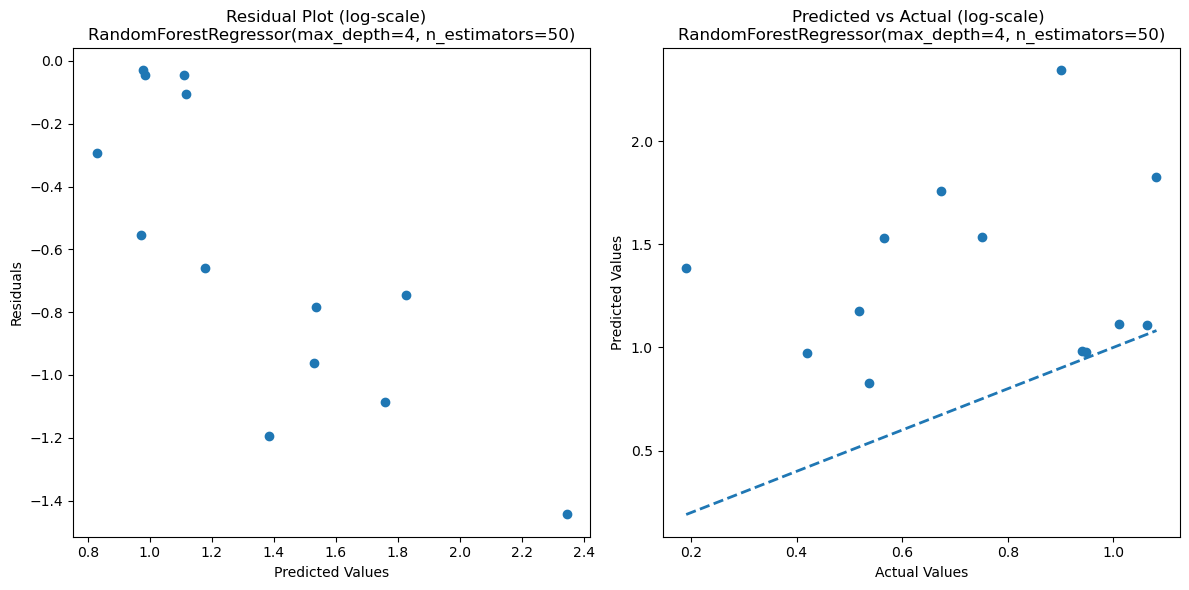

{'rmse_original': 0.8935584445739223,
 'rmse_log': 0.7661092249137366,
 'mae': 0.6110301973058853}

In [178]:
rF_model_val = load('randomForReg_tuned3.pkl')
validate(rF_model_val, X_test=X_test_below_75, y_test=y_test_below_75, scoring=['rmse', 'mae'], plot=True)

- RMSE and MAE are better compared to using the full test set
- with this subset the burnt area would be overestimated

### Dropping Features and basic Featura engineering

- checking for correlation
- drop month and day because of low feature importance and for simplicity reason


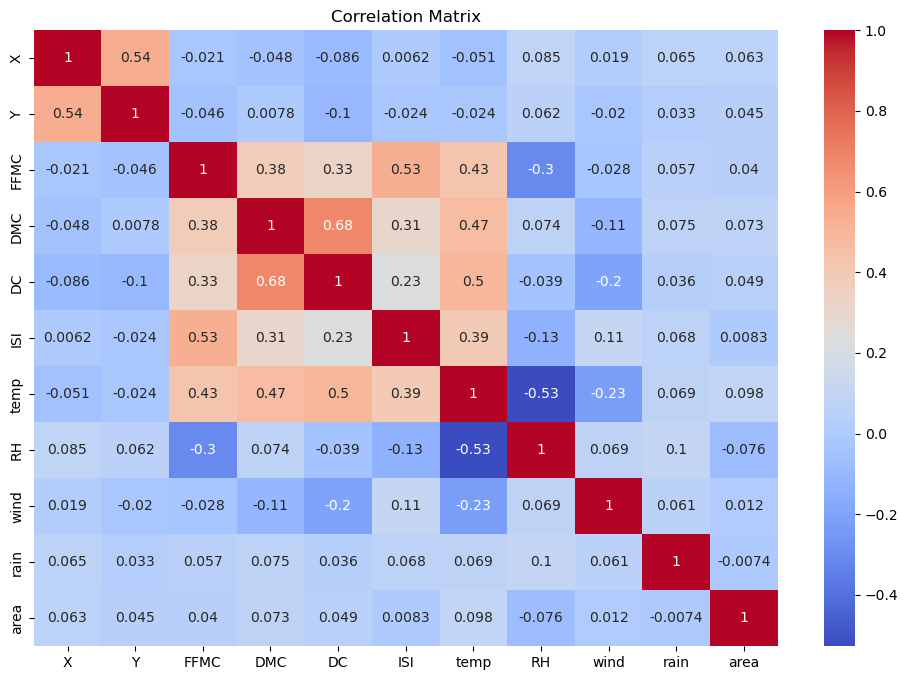

In [179]:
corr_matrix = fire_data.drop(columns=['month', 'day'], axis=1).corr(method='pearson')

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

![Alt text](image-3.png)

- temp has highest correlation with target
- but all features have low correlation with target meaning that none of them is a strong predictor alone
- FFMC, ISI, DMC, DC have high correlation and could introduce colinearity
- rain has low correlation with all other feature and might not be important, backed up by feature importance
- temp and RH have a stronger negative correlation, could be combined and created as new feature

- feature importance is just as an indicator, it is not guaranteed that the model can capture the real importance
- dropping features under a threshhold of 0.05
- to keep both spatial information X and Y

- combine correlated features with simple addition

> domain knowledge

- temperature and RelativeHumidity: environmental variables with impact on likelihood and spread of a fire
- DC and DMC: indicators of moisture content but in different types of fuel, "how dry is the ground"

In [180]:
#print(importance_df)
keep_features = importance_df[importance_df['Importance'] >= 0.05]
print(keep_features)
X_train_dropped, y_train_dropped = preproc_df(X_train, y_train)
X_train_dropped = X_train_dropped[list(keep_features['Feature'])]
X_test_dropped, y_test_dropped = preproc_df(X_test, y_test)
X_test_dropped = X_test_dropped[list(keep_features['Feature'])]

X_train_dropped['DC+DMC_zs'] = X_train_dropped['DC_zs'] + X_train_dropped['DMC_zs']
X_train_dropped = X_train_dropped.drop(columns=['DC_zs', 'DMC_zs'])
# temp +  RH
X_train_dropped['temp+RH_zs'] = X_train_dropped['temp_zs'] + X_train_dropped['RH_logzs']
X_train_dropped = X_train_dropped.drop(columns=['temp_zs', 'RH_logzs'])
# DC + DMC
X_test_dropped['DC+DMC_zs'] = X_test_dropped['DC_zs'] + X_test_dropped['DMC_zs']
X_test_dropped = X_test_dropped.drop(columns=['DC_zs', 'DMC_zs'])
# temp +  RH
X_test_dropped['temp+RH_zs'] = X_test_dropped['temp_zs'] + X_test_dropped['RH_logzs']
X_test_dropped = X_test_dropped.drop(columns=['temp_zs', 'RH_logzs'])

    Feature  Importance
5   temp_zs    0.203406
2    DMC_zs    0.159215
7  RH_logzs    0.115095
6   wind_zs    0.085520
8  X_minmax    0.083209
4    ISI_zs    0.071827
3     DC_zs    0.067135
9  Y_minmax    0.054461
 Preprocessing: standardized
 Preprocessing: standardized


ridgeRegression


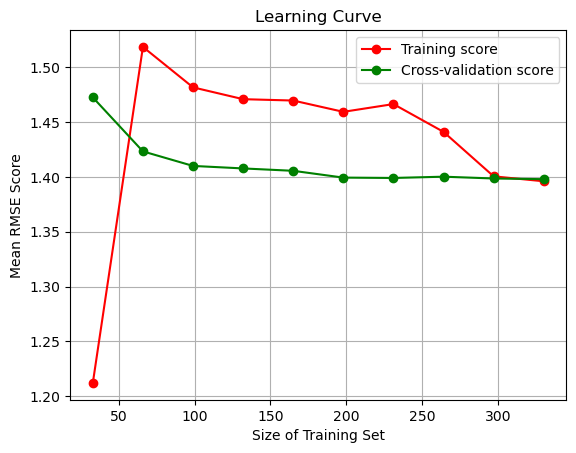

[[1.08433753 1.29680352 1.30349052 1.17166045 1.20377689]
 [1.54929295 1.60423189 1.53068261 1.38389998 1.52544649]
 [1.51421745 1.45669953 1.51877051 1.40134925 1.51797709]
 [1.54589973 1.45952487 1.52320598 1.35965138 1.46677365]
 [1.51815721 1.40751942 1.49569103 1.42092463 1.50656097]
 [1.51250904 1.39924944 1.49536975 1.39200555 1.49814739]
 [1.51618262 1.43057232 1.49630772 1.3899608  1.49966376]
 [1.47557204 1.40143782 1.475865   1.37875292 1.47419109]
 [1.43287235 1.36167533 1.4346898  1.33845364 1.43527736]
 [1.42981628 1.34559795 1.43081538 1.34076948 1.4332842 ]]
Ridge(alpha=3.5)


In [181]:
a_model = get_model(model_name='ridgeRegression')
param_grid = {"alpha": np.array(np.arange(1, 4, 0.5)), "fit_intercept": [False, True]}
# fit_intercept seems to be always chosen as true, model returned withouth the parameter,
# but if i force to be [False, False] then model will be returned with fit_intercept=False.
binning = [-np.inf, 0.01, 0.52, 1090.84]
bin_label = [1, 2, 3]

# standardize False because preproc after dropping features
rmse_ridge, ridgeReg_tuned4 = evaluate_model3(X_train_dropped, y_train_dropped,
                a_model,
                param_grid=param_grid,
                standardize=False,
                thr_bins=binning,
                bin_label=bin_label,
                kfolds=5,
                plot=True)
dump(ridgeReg_tuned4, 'ridgeReg_tuned4.pkl') # save the model as .pkl
print(rmse_ridge)
print(ridgeReg_tuned4)


RMSE: 1.3366820125178676
RMSE original: 2.2293120232958494 hectar
MAE: 1.1357797622195425


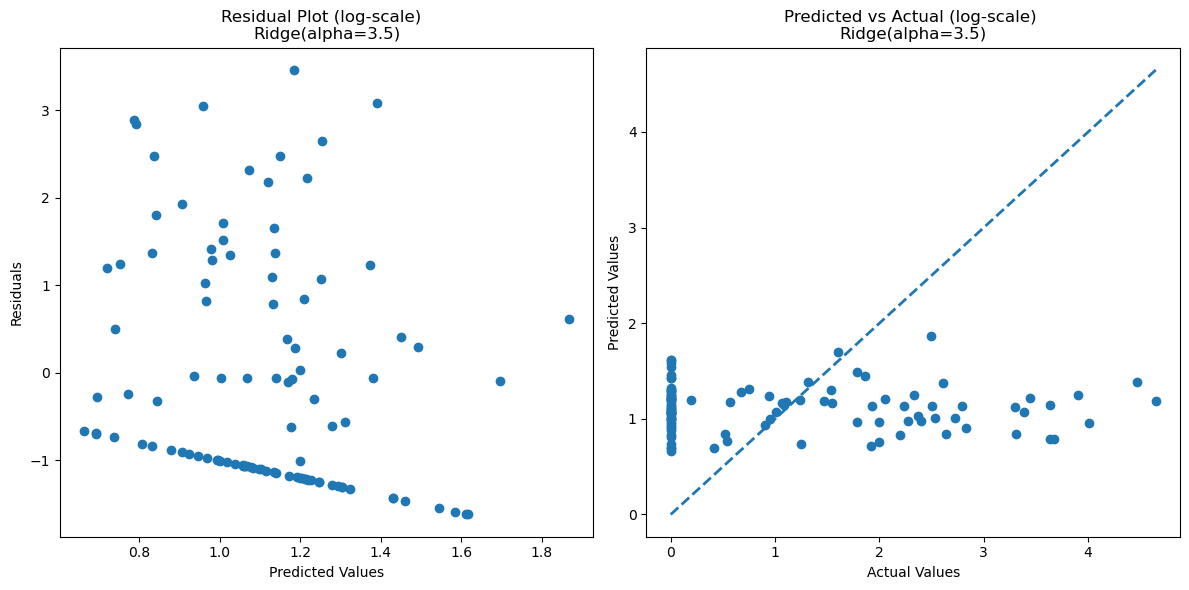

{'rmse_original': 2.2293120232958494,
 'rmse_log': 1.3366820125178676,
 'mae': 1.1357797622195425}

In [182]:
ridge_model_val = load('ridgeReg_tuned4.pkl')
validate(ridge_model_val, X_test=X_test_dropped, y_test=y_test_dropped, preproc=False, scoring=['rmse', 'mae'], plot=True)

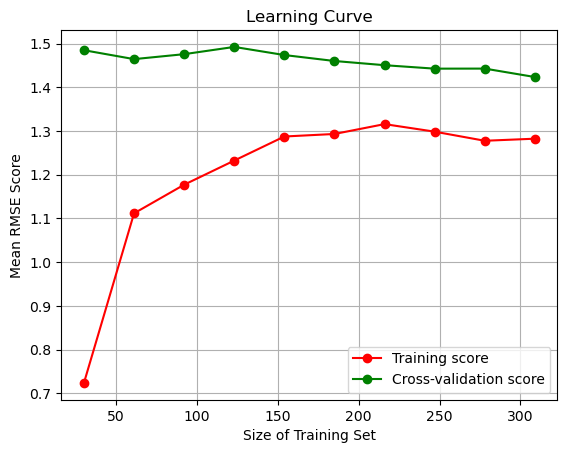

['randomForReg_tuned4.pkl']

In [183]:
a_model = get_model(model_name='randomForest')
param_grid = {"n_estimators": np.array(np.arange(50, 70, 1)), "max_depth": list(np.arange(3, 20, 1))}
binning = [-np.inf, 0.01, 0.52, 1090.84]
bin_label = [1, 2, 3]

rmse_rf, randomForReg_tuned4 = evaluate_model3(X_train_dropped, y_train_dropped,
                a_model,
                param_grid=param_grid,
                standardize=False,
                thr_bins=binning,
                bin_label=bin_label,
                kfolds=4,
                plot=True)
dump(randomForReg_tuned4, 'randomForReg_tuned4.pkl')

RMSE: 1.3215554416250215
RMSE original: 2.1759014573106596 hectar
MAE: 1.1199046483403452


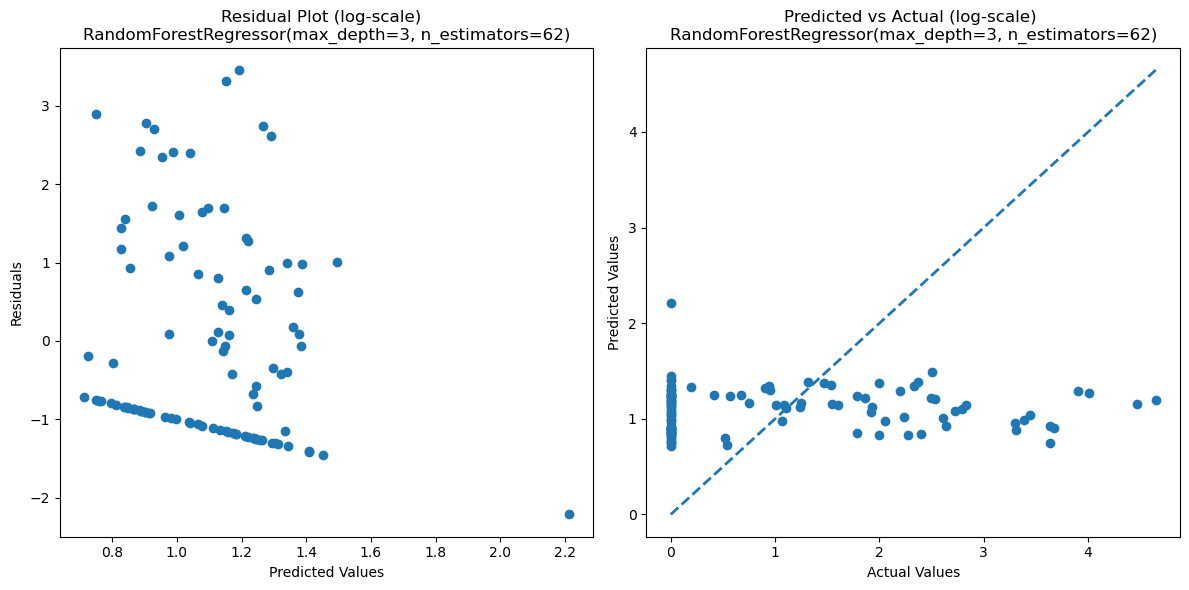

{'rmse_original': 2.1759014573106596,
 'rmse_log': 1.3215554416250215,
 'mae': 1.1199046483403452}

In [184]:
rF_model_val = load('randomForReg_tuned4.pkl')
validate(rF_model_val, X_test=X_test_dropped, y_test=y_test_dropped, scoring=['rmse', 'mae'], plot=True ,preproc=False)

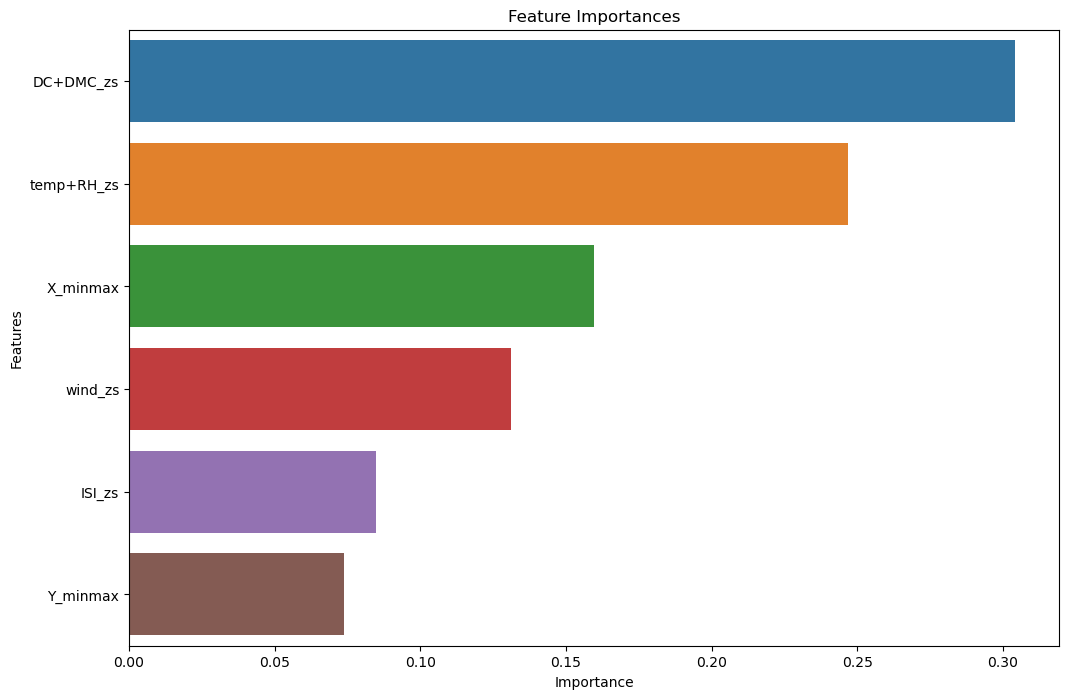

RandomForestRegressor(max_depth=3, n_estimators=62)


In [185]:
rf_model = load('randomForReg_tuned4.pkl')
feature_importances = rf_model.feature_importances_

# feature names
feature_names = X_train_dropped.columns

# create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# print(importance_df)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
print(rf_model)